In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-03-30 18:29:19--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.007s  

2021-03-30 18:29:19 (9.77 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



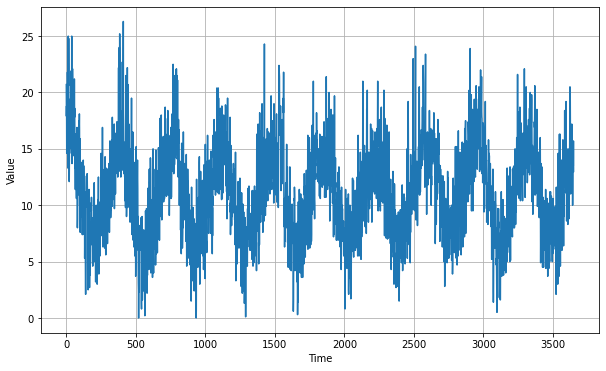

In [5]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 60
batch_size = 122
shuffle_buffer_size = 1000


In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [8]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size=60
batch_size=122
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(300, return_sequences=True),
  tf.keras.layers.LSTM(200, return_sequences=True),
  tf.keras.layers.LSTM(100, return_sequences=True),
  tf.keras.layers.Dense(90, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=200, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/200
20/20 [==============================] - 36s 34ms/step - loss: 10.3577 - mae: 10.8565
Epoch 2/200
20/20 [==============================] - 1s 27ms/step - loss: 10.4116 - mae: 10.9103
Epoch 3/200
20/20 [==============================] - 1s 27ms/step - loss: 10.4156 - mae: 10.9143
Epoch 4/200
20/20 [==============================] - 1s 27ms/step - loss: 10.3455 - mae: 10.8442
Epoch 5/200
20/20 [==============================] - 1s 26ms/step - loss: 10.3586 - mae: 10.8573
Epoch 6/200
20/20 [==============================] - 1s 26ms/step - loss: 10.3327 - mae: 10.8314
Epoch 7/200
20/20 [==============================] - 1s 27ms/step - loss: 10.4296 - mae: 10.9284
Epoch 8/200
20/20 [==============================] - 1s 27ms/step - loss: 10.3690 - mae: 10.8678
Epoch 9/200
20/20 [==============================] - 1s 27ms/step - loss: 10.3521 - mae: 10.8508
Epoch 10/200
20/20 [====

(1e-06, 0.1, 0.0, 60.0)

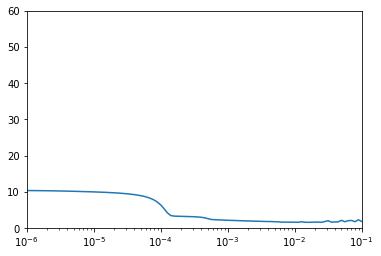

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-1, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size=60
batch_size=122
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer=shuffle_buffer_size)
valid_set=windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(300, return_sequences=True),
  tf.keras.layers.LSTM(200, return_sequences=True),
  tf.keras.layers.LSTM(100, return_sequences=True),
  tf.keras.layers.Dense(90, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  #tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-3, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoint2.h5", save_best_only=True)
#early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
history = model.fit(train_set, validation_data=valid_set, epochs=250,callbacks=[model_checkpoint])


Epoch 1/250
20/20 [==============================] - 6s 104ms/step - loss: 10.1144 - mae: 10.6130 - val_loss: 9.6113 - val_mae: 10.1100
Epoch 2/250
20/20 [==============================] - 1s 41ms/step - loss: 7.9236 - mae: 8.4189 - val_loss: 3.5615 - val_mae: 4.0347
Epoch 3/250
20/20 [==============================] - 1s 39ms/step - loss: 3.5092 - mae: 3.9818 - val_loss: 3.5588 - val_mae: 4.0318
Epoch 4/250
20/20 [==============================] - 1s 40ms/step - loss: 3.3433 - mae: 3.8143 - val_loss: 3.1752 - val_mae: 3.6490
Epoch 5/250
20/20 [==============================] - 1s 40ms/step - loss: 3.1811 - mae: 3.6527 - val_loss: 3.1693 - val_mae: 3.6423
Epoch 6/250
20/20 [==============================] - 1s 39ms/step - loss: 3.1201 - mae: 3.5890 - val_loss: 3.1001 - val_mae: 3.5719
Epoch 7/250
20/20 [==============================] - 1s 40ms/step - loss: 3.0465 - mae: 3.5146 - val_loss: 2.9811 - val_mae: 3.4508
Epoch 8/250
20/20 [==============================] - 1s 40ms/step - loss

In [20]:
history = model.fit(train_set, validation_data=valid_set, epochs=50,callbacks=[model_checkpoint])

Epoch 1/50
20/20 [==============================] - 1s 44ms/step - loss: 1.4172 - mae: 1.8522 - val_loss: 1.3437 - val_mae: 1.7828
Epoch 2/50
20/20 [==============================] - 1s 40ms/step - loss: 1.4186 - mae: 1.8536 - val_loss: 1.3471 - val_mae: 1.7867
Epoch 3/50
20/20 [==============================] - 1s 41ms/step - loss: 1.4198 - mae: 1.8546 - val_loss: 1.3492 - val_mae: 1.7886
Epoch 4/50
20/20 [==============================] - 1s 41ms/step - loss: 1.4271 - mae: 1.8625 - val_loss: 1.3477 - val_mae: 1.7862
Epoch 5/50
20/20 [==============================] - 1s 40ms/step - loss: 1.4205 - mae: 1.8555 - val_loss: 1.3565 - val_mae: 1.7930
Epoch 6/50
20/20 [==============================] - 1s 40ms/step - loss: 1.4210 - mae: 1.8557 - val_loss: 1.3485 - val_mae: 1.7856
Epoch 7/50
20/20 [==============================] - 1s 41ms/step - loss: 1.4152 - mae: 1.8505 - val_loss: 1.3459 - val_mae: 1.7851
Epoch 8/50
20/20 [==============================] - 1s 40ms/step - loss: 1.4220 - m

Text(0.5, 1.0, 'Training and validation loss')

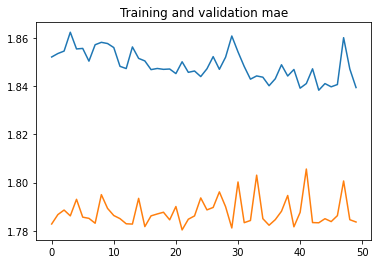

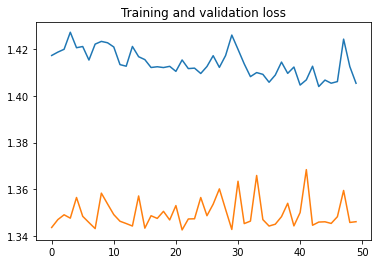

In [21]:
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae      = history.history[     'mae' ]
val_mae  = history.history[ 'val_mae' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(mae)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     mae )
plt.plot  ( epochs, val_mae )
plt.title ('Training and validation mae')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

ValueError: ignored

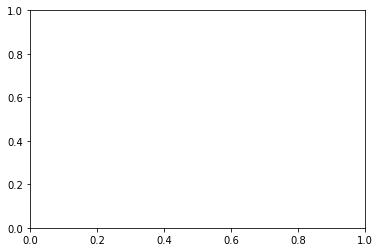

In [22]:
epochs   = range(len(mae))
zoom_point=len(mae)-80
zoomed_mae = mae[zoom_point:]
zoomed_v_mae = val_mae[zoom_point:]
zoomed_epochs = range(zoom_point,len(mae))


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_mae, 'b')
plt.plot(zoomed_epochs, zoomed_v_mae, 'r')

In [23]:
model = tf.keras.models.load_model("my_checkpoint2.h5")

In [24]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

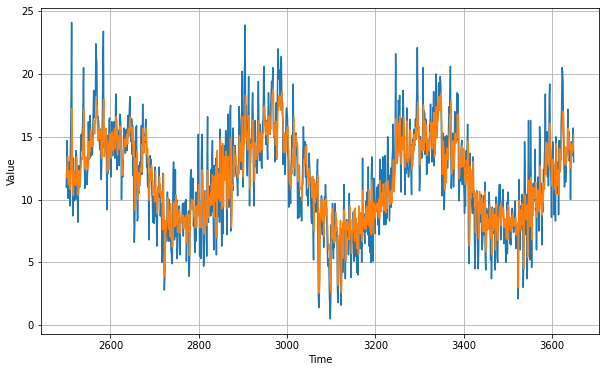

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [26]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7623441

In [27]:
print(rnn_forecast)

[11.980639 11.785506 12.716306 ... 13.937058 14.034931 15.139718]
